# Toy example from Section 3.1

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from haplm.hap_util import mat_by_marker

In [2]:
from matplotlib import rc, rcParams

# comment out if tex is not installed
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=16)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [3]:
def mn_manual(p, y, amat, n):
    """Calculate multinormal approximation of latent multinomial likelihood"""
    delta = y-(amat@p)*n
    aq = np.dot(amat, p)
    chol = np.linalg.cholesky(n*(np.dot(amat*p, amat.T)-np.outer(aq, aq)+np.eye(2)*1e-9))
    chol_inv_delta = scipy.linalg.solve_triangular(chol, delta, lower=True)
    return - np.log(2*np.pi) - 0.5*np.dot(chol_inv_delta, chol_inv_delta) - np.sum(np.log(np.diag(chol)))

In [4]:
def exact_manual(p, y, n):
    """Calculate exact latent multinomial likelihood for the 2 marker toy example"""
    lo = max(0, y[0]+y[1]-n)
    hi = min(y[0], y[1])
    zs = [np.array([n+both-y[0]-y[1], y[0]-both, y[1]-both, both]) for both in range(lo, hi+1)]
    return logfacts[n] + scipy.special.logsumexp([sum(np.log(pval)*zval if pval else (-np.inf if zval > 0 else 0)
                                                      for pval, zval in zip(p, z))
                                                  - np.sum(logfacts[z]) for z in zs])

In [5]:
def smax(clog):
    """Softmax transformation"""
    cexp = np.exp([0]+list(clog))
    return cexp/np.sum(cexp)

In [6]:
amat = mat_by_marker(2)
n = 100
logfacts = scipy.special.loggamma(np.arange(1, 102))

In [7]:
# verify that exact MLE is one of (0.5, 0.5 − y2/n, 0, y2/n) or (0.5 − y2/n, 0.5, y2/n, 0)
for y2 in tqdm(range(51)):
    y1 = n // 2
    y = [y1, y2]
    for t in range(5):        
        # transform to unconstrained domain for optimisation
        centred = np.random.dirichlet(np.ones(4))
        clog = np.log(centred)
        clog = clog[1:]-clog[0]
        res = scipy.optimize.minimize(lambda clog: -exact_manual(smax(clog), y, n), clog, tol=1e-10)
        if t == 0 or res.fun < sofar.fun:
            sofar = res        
    mle = smax(sofar.x)  
    targets = [np.array([0.5, 0.5 - y2/n , 0, y2/n]), np.array([0.5 - y2/n, 0.5, y2/n, 0])]
    assert any(np.isclose(mle, target, atol=1e-4).all() for target in targets)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:16<00:00,  3.12it/s]


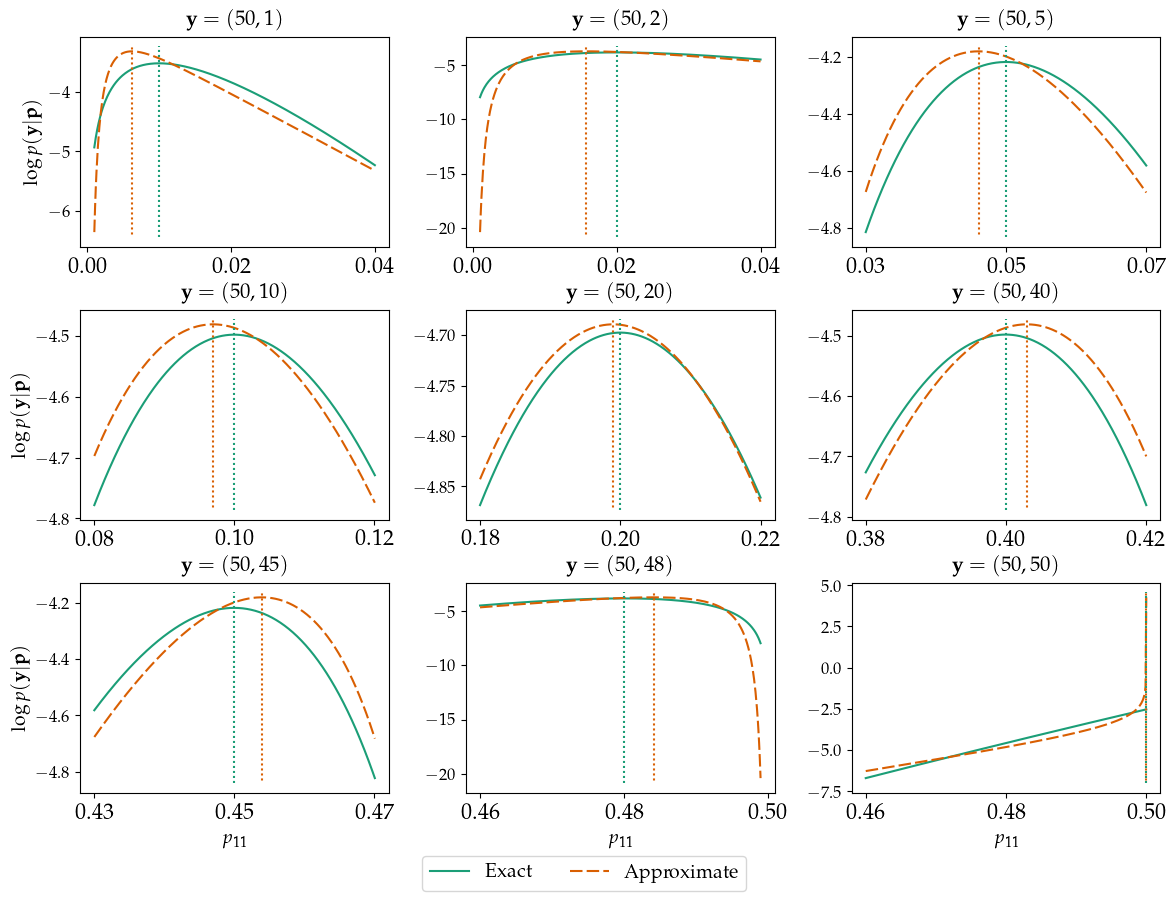

In [8]:
n = 100
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
for i in range(9):
    r = i // 3
    c = i % 3
    ax = axes[r,c]
    y2 = [1,2,5,10,20,40,45,48,50][i]
    y = [n // 2, y2]
    
    # set p-grid for edge cases
    x = p11_arr = np.arange(max(0.001, y[1]/n-0.02), min(0.5, y[1]/n+0.0201), 0.0001)
    if i == 8:
        x = p11_arr = np.arange(0.46, 0.50005, 0.0001)
    if i == 7:
        x = p11_arr = np.arange(0.46, 0.49905, 0.0001)
    if i == 0:
        x = p11_arr = np.arange(0.001, 0.04005, 0.0001)
    n_arr = len(p11_arr)
    p_arr = np.array([np.ones(n_arr)*0.5, 0.5-p11_arr, np.zeros(n_arr), p11_arr]).T
    
    # plot likelihood curves
    mn_logps = [mn_manual(p, y, amat, n) for p in p_arr]
    exact_logps = [exact_manual(p, y, n) for p in p_arr]
    ax.plot(x, exact_logps, color=colors[0], label='Exact');
    ax.plot(x, mn_logps, '--', color=colors[1], label='Approximate', dashes=(6, 2));    
    
    # plot MLEs
    ylims = ax.get_ylim()
    ymin = 0.98*ylims[0]+0.02*ylims[1]
    ymax = 0.02*ylims[0]+0.98*ylims[1]
    emax = x[np.argmax(exact_logps)]
    amax = x[np.argmax(mn_logps)]
    ax.plot([emax, emax], [ymin, ymax], color=colors[0], linestyle=(0, (1, 1.4)))
    ax.plot([amax, amax], [ymin, ymax], color=colors[1], linestyle=(1.2, (1, 1.4)))
    
    # make x-ticks consistent
    pcent = np.clip(y[1]/n, 0.02, 0.48)
    xticks = np.arange(pcent-0.02, pcent+0.021, 0.02)
    ax.set_xticks(xticks)
    
    ax.set_title(r'$\mathbf{y}$ ' + f'$ = ({y[0]}, {y[1]})$', fontsize=15, pad=8.0)
    ax.tick_params(axis='y', which='both', labelsize=12)
    if r == 2:
        ax.set_xlabel('$p_{11}$', fontsize=14)
    if c == 0:
        ax.set_ylabel(r'$\log p(\mathbf{y}\vert\mathbf{p})$', fontsize=14)
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.0), fontsize=14)
plt.subplots_adjust(hspace=0.3, wspace=0.25, top=0.96, left=0.08, right=0.98, bottom=0.12);
plt.savefig('mn_acc.png', dpi=200, facecolor='white');